# Advanced Programming for Data Science
*Code proposition done by:*
```
Farouq El-Abbass
Moritz Häckel
Dominik Trut
Moritz Güttersberger
```

Our project consisted of creating a module for studying the energy production and consumption per country, and as well the produced CO2 for each energy source.

We are going to start by *importing* the libraries we have used

In [1]:
import requests
import pandas as pd
import os
import plotly_express as px
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import statsmodels.api as sm
from pmdarima import auto_arima
style.use("ggplot")

### Our proposition for the class is as follows:

In [2]:
class Energy():

    def __init__(self, data=None):
        """
        Constructs all the necessary attributes for the person object.

        Parameters
        -----------
        data : panda dataframe
            Data for the Energy but will be affected later

        Returns
        --------
        Nothing, it's just a contructor
        """
        self.data = data

    def read_data(self, drop_continents: bool = False,
                  url="https://github.com/owid/energy-data/raw/" +
                  "master/owid-energy-data.csv"):
        """
        Downloads the owid data in the ´/downloads´ folder, cleans it,
        and reads data as well

        Parameters
        -----------
        url: string
            Link of the data from internet
        drop_continents: bool
            Drops continents and aggregated countries from dataset

        Returns
        --------
        df: pandas dataframe
            Dataframe of the data including consumption and emissions,
            cleaned dataset from NAN, with an index of timestamp
        """
        path = os.getcwd()
        if os.path.exists(os.getcwd()+'/downloads') is False:
            os.mkdir(path+"/downloads")
        else:
            pass

        if os.path.isfile("./downloads/data.csv") is True:
            pass
        else:
            req = requests.get(url)
            url_content = req.content
            csv_file = open('./downloads/data.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()

        self.data = pd.read_csv("./downloads/data.csv")
        self.data = self.data[self.data["year"] >= 1970]
        if drop_continents is True:
            self.data = self.data.dropna(
                subset=['iso_code'])
            self.data = self.data.set_index("country").drop("World")
            self.data = self.data.reset_index()

        else:
            pass

        self.data["timestamp"] = pd.DatetimeIndex(pd.to_datetime(
            self.data["year"], format="%Y")).year
        self.data = self.data.set_index("timestamp")

        # enrich data with 'emissions'
        self.data["biofuel_emission"] = self.data["biofuel_electricity"] * \
            1450*(10**3)
        self.data["coal_emission"] = self.data["coal_electricity"]*1000*(10**3)
        self.data["gas_emission"] = self.data["gas_electricity"]*455*(10**3)
        self.data["hyrdo_emission"] = self.data["hydro_electricity"]*90*(10**3)
        self.data["nuclear_emission"] = self.data["nuclear_electricity"] * \
            5.5*(10**3)
        self.data["oil_emission"] = self.data["oil_electricity"]*1200*(10**3)
        self.data["solar_emission"] = self.data["solar_electricity"]*53*(10**3)
        self.data["wind_emission"] = self.data["wind_electricity"]*14*(10**3)

        self.data["emissions"] = self.data[["biofuel_emission",
                                            "coal_emission",
                                            "gas_emission",
                                            "hyrdo_emission",
                                            "nuclear_emission",
                                            "oil_emission",
                                            "solar_emission",
                                            "wind_emission"]].sum(axis=1)

        # add total consumption for later computation
        self.data["total_consumption"] = self.data[[
            "biofuel_consumption",
            "coal_consumption",
            "gas_consumption",
            "hydro_consumption",
            "nuclear_consumption",
            "oil_consumption",
            "solar_consumption",
            "wind_consumption"]].sum(axis=1)

        # drop zeros of population
        self.data['population'] = self.data['population'].fillna(0)

        return self.data

    def countries_list(self):
        """
        Returns the list of countries in the data

        Parameters
        ----------
        None

        Returns
        -------
        country_list : list
            List of countries in the dataframe

        """
        countries = self.data["country"].unique()
        return countries.tolist()

    def gdp_over_years(self, countries):
        """
        Receive a string or a list of strings -> Compare the "gdp" column of
        each received country over the years

        Parameters
        ----------
        countries : list of strings
            DESCRIPTION. Name of every country that is included

        Returns
        -------
        gdp_over_years_df: pandas Dataframe
            DESCRIPTION: GPD of countries over the years
                columns = Countries
                index = years
        """
        if type(countries) != str:
            raise TypeError("Variable countries not a string.")
        if countries not in self.countries_list():
            raise TypeError("ValueError: country not found")

        df = self.data
        cut = df[["year", "country", "gdp"]]
        gdp_over_years_df = cut.pivot(
            index="year", columns="country", values="gdp")

        return gdp_over_years_df[countries]

    def consumption_country(self, countries):
        """
        The method produces a dataframe with defined countries in columns and
        all years in rows. Values are the sum of the total energy consumption
        of the country.

        Parameters
        ----------
        countries : list of strings
            A list of countries that are included in the consumption per
            country dataframe

        Returns
        -------
        Bar Plot:
            Displays the bar plot of the total consumption for each
            country.

        """
        if type(countries) != list:
            raise TypeError("TypeError: countries not list")
        if countries not in self.countries_list():
            raise ValueError("ValueError: country not in dataset")

        df = self.data[["country", "biofuel_consumption",
                        "coal_consumption",
                        "gas_consumption",
                        "hydro_consumption",
                        "nuclear_consumption",
                        "oil_consumption",
                        "solar_consumption",
                        "wind_consumption",
                        "emissions"]]
        df = df.groupby("country").sum()
        df["total_consumption"] = df.iloc[:, :8].sum(axis=1)
        df = df.loc[countries]
        return df.reset_index()[["total_consumption",
                                 "emissions", 'country']].plot.bar(
                                     x='country', ec='black',
                                     secondary_y="emissions")

        return df.reset_index().plot.bar(x="country",
                                         y="total_consumption"),
        df['emissions'] = plt.subplots()

    def prepare_df(self, metric):
        """
        The method produces a dataframe of all countries and years for one
        transmitted metric (i.e. GDP or Population).

        Parameters
        ----------
        metric : string
            The name of the column from which values are extracted
            (i.e. "gdp" for values of gdp column).

        Returns
        -------
        metric_df: dataframe
            A dataframe that has all countries in columns and years in rows.
            Values are the defined metric
        """
        if type(metric) != str:
            raise TypeError("TypeError: metric not string")
        if metric not in self.data.columns:
            raise ValueError("ValueError: metric not in dataset")

        df = self.data
        cut = df[["year", "country", metric]]
        metric_df = cut.pivot(
            index="year", columns="country", values=metric)
        return metric_df

    def consumption_area_plot(self, country, normalize):
        """
        Returns an area chart of the '_consumption' columns
        for a selected country

        Parameters
        ----------
        country : string
            country you want to see the area chart for.
        normalize : boolean
            normalize the chart or not.

        Returns
        -------
        area_chart : chart

        """
        if type(country) != str:
            raise TypeError("TypeError: country not string")
        if country not in self.countries_list():
            raise ValueError("ValueError: country not in dataset")

        self.data = self.data.reset_index()
        df = self.data[["country", "year", "biofuel_consumption",
                        "coal_consumption",
                        "gas_consumption",
                        "hydro_consumption",
                        "nuclear_consumption",
                        "oil_consumption",
                        "solar_consumption",
                        "wind_consumption"]]
        dfcountry = df[df["country"] == country]

        if normalize is True:
            df_norm = pd.concat(
                [dfcountry[["country", "year"]],
                 dfcountry.iloc[:, 3:].apply(
                     lambda x: x / x.sum(), axis=1)], axis=1)
            return df_norm.plot.area('year', stacked=True)
        else:
            return dfcountry.plot.area('year', stacked=True)

    def gapminder(self, year):
        """
        This method shows the correlation between gpd, total engery
        consumption and the population for the year passed in the argument.

        Parameters
        ----------
        year : integer
            year you want the chart to display

        Returns
        -------
        px.scatter : chart

        """
        if type(year) != int:
            raise TypeError("TypeError: year not int")
        if year not in self.data['year']:
            raise ValueError("ValueError: Year is not in data")
        df = self.data

        gapminder_df = df[['country', 'year',
                           'gdp', 'population',
                           'total_consumption']].reset_index()
        gapminder_df = gapminder_df[gapminder_df['total_consumption'] != 0]
        px.scatter(
            gapminder_df.query("year == "+str(year)),
            x="gdp",
            y="total_consumption",
            animation_frame="year",
            animation_group="country",
            size="population",
            color="country",
            # hover_name="country",
            log_x=True,
            log_y=True,
            size_max=60).show()

    def allcountries_scatter(self, year):
        """
        This method shows the correlation between emissions, total engery
        consumption and the population for the year passed in the argument.

        Parameters
        ----------
        year : integer
            year you want the chart to display

        Returns
        -------
        px.scatter : chart

        """
        if type(year) != int:
            raise TypeError("TypeError: year not int")
        if year not in self.data['year']:
            raise ValueError("ValueError: Year is not in data")
        scatter_df = self.data[['country', 'year', 'population',
                                'total_consumption', 'emissions']]
        px.scatter(
            scatter_df.query("year == "+str(year)),
            x="emissions",
            y="total_consumption",
            animation_frame="year",
            animation_group="country",
            size="population",
            color="country",
            # hover_name="country",
            log_x=True,
            log_y=True,
            size_max=60).show()

    def arima_forecast(self, country, points: int):
        """
        Method to forecast consumption and emissions for contry passed in
        argument

        Parameters
        ----------
        country : str
            Country for forecasting.
        points : int
            Number of points for forecasting in the future.

        Returns
        -------
        fig: matplotlib figure
            Figure displaying the forecast of consumtion and emissions for
            the country passed in argument

        """
        df = self.data[["country", "total_consumption", "emissions"]]
        df = df[df["country"] == str(country)]
        df = df.replace(0, np.nan)
        df = df.dropna()

        best_consumption = auto_arima(df["total_consumption"],
                                      start_p=3,
                                      start_q=3,
                                      max_p=8,
                                      max_q=8,
                                      max_order=20,
                                      d=None,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=False
                                      )
        coeff_c = best_consumption.order
        model_c = sm.tsa.arima.ARIMA(df["total_consumption"], order=coeff_c)
        model_fit_c = model_c.fit()
        yhat_c = model_fit_c.predict(len(df), len(df)+points)

        best_emissions = auto_arima(df["emissions"],
                                    start_p=3,
                                    start_q=3,
                                    max_p=8,
                                    max_q=8,
                                    max_order=20,
                                    d=None,
                                    trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=False,
                                    )
        coeff_em = best_emissions.order
        model_e = sm.tsa.arima.ARIMA(df["emissions"], order=coeff_em)
        model_fit_e = model_e.fit()
        yhat_e = model_fit_e.predict(len(df), len(df)+points)
        xhat = np.arange(2019, 2019+points+1)

        # plotting
        fig, ax = plt.subplots(2)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.6)

        ax[0].set_title(
            f"Total consumption throughout the years for {country}")
        ax[0].plot(df.index, df["total_consumption"])
        ax[0].plot(xhat, yhat_c)

        ax[1].set_title(f"Total emissions throughout the years for {country}")
        ax[1].plot(df.index, df["emissions"])
        ax[1].plot(xhat, yhat_e)

        fig.show()


In [3]:
china = Energy()

In [4]:
china.read_data(drop_continents=True)

,country,iso_code,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,biofuel_emission,coal_emission,gas_emission,hyrdo_emission,nuclear_emission,oil_emission,solar_emission,wind_emission,emissions,total_consumption
timestamp,,,,,,,,,,,,,,,,,,,,,
1970,Afghanistan,AFG,1970,20.588,0.228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1971,Afghanistan,AFG,1971,-17.683,-0.236,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1972,Afghanistan,AFG,1972,-47.407,-0.521,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1973,Afghanistan,AFG,1973,64.789,0.374,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1974,Afghanistan,AFG,1974,-1.709,-0.016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,Zimbabwe,ZWE,2015,-25.013,-10.847,NaN,NaN,NaN,NaN,-0.789,...,185600.0,4312000.0,0.0,444600.0,0.0,0.0,424.0,0.0,4942624.0,0.0
2016,Zimbabwe,ZWE,2016,-37.694,-12.257,NaN,NaN,NaN,NaN,-14.633,...,213150.0,3715000.0,0.0,265950.0,0.0,0.0,477.0,0.0,4194577.0,0.0
2017,Zimbabwe,ZWE,2017,8.375,1.697,NaN,NaN,NaN,NaN,NaN,...,218950.0,3219000.0,0.0,353610.0,0.0,0.0,583.0,0.0,3792143.0,0.0


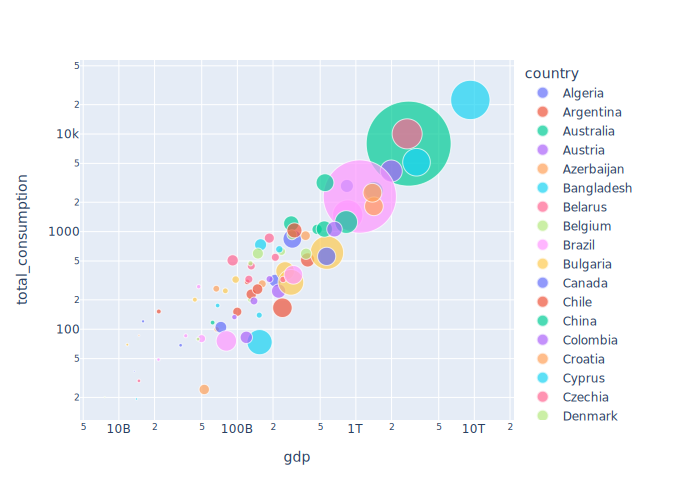

In [5]:
china.gapminder(1990)